In [88]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from itertools import groupby
from operator import itemgetter

In [2]:
plt.matplotlib.__version__, np.__version__, pd.__version__

('2.1.0', '1.16.2', '0.24.1')

In [64]:
root_dir = os.path.abspath("__file__"+"/../../")

In [65]:
sys.path.insert(0,root_dir)

In [66]:
%load_ext autoreload
%autoreload 2

In [68]:
from dsutil import plotting

In [3]:
y_trues = np.random.choice([0,1],size=100)

In [4]:
y_preds = np.random.uniform(low=0,high=1,size=100)

In [50]:
arr = np.array([0.12,0.23,0.90,.04,0.91,0.46,0.55,0.99])
arr

array([0.12, 0.23, 0.9 , 0.04, 0.91, 0.46, 0.55, 0.99])

In [52]:
score_bins = np.arange(0,1,0.05)
score_bins

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [53]:
hist, bin_edges = np.histogram(arr,bins=score_bins)
hist, bin_edges

(array([1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]))

In [54]:
bin_indexes = np.digitize(arr,bin_edges)
bin_indexes

array([ 3,  5, 19,  1, 19, 10, 12, 20])

In [55]:
bin_edges[bin_indexes-1]

array([0.1 , 0.2 , 0.9 , 0.  , 0.9 , 0.45, 0.55, 0.95])

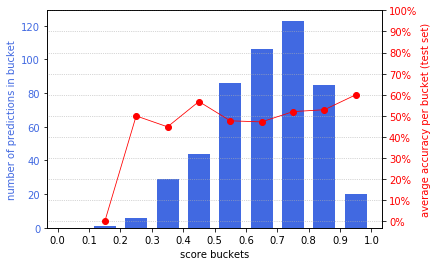

In [240]:
def calibration_accuracy_plot(y_true,y_pred,ax=None):
    
    if y_true.shape != y_pred.shape:
        raise ValueError(
            'Expected y_true and y_pred to have the same shapes, got {} and {}'.format(y_true.shape, y_pred.shape))
        
    y_label_left = 'number of predictions in bucket'
    y_label_right = 'average accuracy per bucket (test set)'
    x_label = 'score buckets'
    main_color = 'royalblue'
    secondary_color = 'red'
    bar_width = 0.7    
        
    num_bins = 10
    
    min_x = 0.0
    max_x = 1.0
    
    epsilon = 0.001
    
    score_bins = np.arange(0,1,(1.0/num_bins))
    # need to add epsilon otherwise arange wont include the last number
    score_bins_with_endpoint = np.arange(0,1+epsilon,(1.0/num_bins))
   
    # hist contains the number of elements per bin
    hist, bin_edges = np.histogram(y_pred,bins=score_bins)

    bin_edges_with_right_edge = np.append(bin_edges,1.0)
    
   
    bin_indexes = np.digitize(y_pred,bin_edges)
    element_bins = bin_edges[bin_indexes-1]
        
    if ax is None:
        ax = plt.gca()
    
    ax.hist(
        y_pred,
        bins=score_bins_with_endpoint,
        rwidth=bar_width,
        color=main_color
    )
       
    ax.set_ylabel(y_label_left,color=main_color)
        
    # make a 2d list of the form [bucket,actual,score]
    # [
    #  [ 0.90 , 1 , 0.92 ],  
    #  [ 0.80 , 0 , 0.81 ],  
    #  [ 0.55 , 0 , 0.55 ]  
    # ]
    merged = np.hstack([
        element_bins.reshape(-1,1),
        y_true.reshape(-1,1),
        y_pred.reshape(-1,1)
    ])
#     print('merged:')
#     print(merged)
    
#     merged_sorted = np.sort(merged,axis=1)
    merged_sorted = merged[merged[:,0].argsort()]
#     print('merged sorted')
#     print(merged_sorted)
    # https://stackoverflow.com/a/43094244
    grouped = np.split(merged_sorted[:, 1], np.cumsum(np.unique(merged_sorted[:, 0], return_counts=True)[1])[:-1])
    
#     print('grouped')
#     print(grouped)
    
    averages_by_bucket = np.hstack([
        np.unique(merged_sorted[:, 0]).reshape(-1,1),
        np.array([np.mean(g) for g in grouped]).reshape(-1,1)
    ])
    
#     print('averages by bucket')
#     print(averages_by_bucket)
    
    y_labels = ax.get_yticks()
    y_labels_as_int = [int(l) for l in y_labels]
    
    ax.set_yticklabels(y_labels_as_int, color=main_color)
    
    ax2 = ax.twinx()
    
    slack_x = 0.05 # must be half the width of one bucket
    ax2.plot(averages_by_bucket[:,0]+slack_x,averages_by_bucket[:,1],'ro-',linewidth=0.8)
    ax2.set_yticks(np.arange(0,1.05,0.1))
    ax2.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax2.get_yticks()],color='red')
    ax2.set_ylabel(y_label_right,color=secondary_color)
    
#     plotting.add_grid(ax)
    plotting.add_grid(ax2)
    
    ax.set_xlabel(x_label)
    ax.set_xticks(score_bins_with_endpoint)
    
    plt.show()
        
# np.random.seed(100)
# using the beta distribution to have more scores on the right
scores = np.random.beta(6,3,500)
# print(scores)
actual_values = np.random.choice([0.0,1.0],500)
# print(actual_values)
calibration_accuracy_plot(actual_values, scores)

In [ ]:
y_label_left = 'frequency of scores in bucket'
y_label_right = 'average accuracy per bucket (test set)'
main_color = 'royalblue'
secondary_color = 'red'

plt.clf()

ax1 = plt.gca()

score_bins = np.arange(0,1,0.05)

ax1.hist(
    y_preds,
    bins=score_bins,
    rwidth=0.7,
    align='mid',
    color=main_color)

ax1.set_ylabel(y_label,color=main_color)

ax2 = ax1.twinx()

# make a list of the form score, actual, bucket
# [
#  [ 0.92, 1 , 0.90],  
#  [ 0.83, 0 , 0.80],  
#  [ 0.58, 0 , 0.55]  
# ]
merged = np.hstack([
    
])


# # then group by the bucket and get the avg score by bucket
# for groupByID, rows in groupby(arr, key=itemgetter(2)):
#     position1, position2, counter = 0, 0, 0
#     for row in rows:
#         position1+=row[0]
#         position2+=row[1]
#         counter+=1
#     result.append([position1/counter, position2/counter, groupByID])

# # plot the red line
    
# plt.show()

In [ ]:
plt.clf()

# barrinhas no ax1
ax1 = plt.gca()
top_scores_df['top_predicted_score'].plot(
    kind='hist',bins=np.arange(0,101,5),rwidth=0.7,align='mid',ax=ax1,color='royalblue')

ax1.set_yticks(np.arange(0,1010,50))
vals = ax1.get_yticks()
ax1.set_ylabel('Número de predições por bucket')

# linhas no ax2
ax2 = ax1.twinx()

grouped_df = top_scores_df.groupby('bucket')['match'].mean().to_frame().reset_index()
buckets = grouped_df.bucket.values.astype(int)
avg_accuracies = grouped_df.match.fillna(np.nan).values

# o + 2.5 é só pra alinhar no eixo x
ax2.plot([b+2.5 for b in buckets],avg_accuracies,'ro-',linewidth=0.8)

# as percentagens

ax2.set_yticks(np.arange(0,1.05,0.05))
ax2.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax2.get_yticks()],color='red')
ax2.set_ylabel('Average accuracy',color='red')
# ax2.set_xticks(buckets)

# plotting.add_grid(ax=ax1)
plotting.add_grid(ax=ax2)
plotting.plot_value_labels(format="{:.0f}",ax=ax1)
plt.xticks(np.arange(0,101,5))
ax1.xaxis.set_ticks_position('bottom')
plt.gcf().set_size_inches(7,5)
plt.suptitle(
    'TEST SET \n'+
    'DROP INTER-MOMENT TRANSITIONS={} \nDROP-INTER FASE TRANSITIONS={} \nMAX_AGE={} \nACCURACY={:.2f}%'.format(DROP_INTRA_MOMENT,DROP_INTRA_FASE, MAX_TEXT_AGE,accuracy),
    y=1.08)
plt.show()

## add an example of a well-calibrated model with roughly constant frequency by bucket

## add an example of a well-calibrated model but with most scores in the lower buckets

## add an example of a model with missing scores in a bucket